In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import r2_score
import pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch
import sys
sys.path.insert(1, '../fit')
from dnn_setup import ResNetRegressor, ResidualBlock

In [45]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/params')
from ltar_gb_params_eval import *

In [54]:
from importlib import reload
reload(sys.modules["ltar_gb_params_eval"])
from ltar_gb_params_eval import *

In [55]:
with open(os.path.join(inDIR, 'ml_train_' + nickname + '_cv_' + kfold_group + '_tuneby_' + tuneby_group + '_results.pk'), 'rb') as f:
    mod_dict = pickle.load(f)
df = pd.read_csv(inPATH)
save_results = False

In [56]:
id_cols

['id', 'pasture', 'date_median', 'year', 'Observed']

In [57]:
keep_cols = var_names + id_cols + [logo_group, y_col, date_col, past_col, id_col] + group_cols + list(mod_dict.keys())

In [58]:
drop_cols = [x for x in df.columns if x not in keep_cols]

In [59]:
drop_cols

['Lat',
 'long',
 'forb_kg_ha',
 'grass_kg_ha',
 'litter_kg_ha',
 'season',
 'low',
 'high',
 'shape',
 'radius_m',
 'herb_kg_ha_old',
 'site',
 'g.m2',
 'Year']

In [60]:
def r_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    r = corr
    return r

In [61]:
df_bm_pred = pd.melt(df.drop(columns=drop_cols + var_names).rename(columns={y_col: 'Observed'}), 
                 id_vars=id_cols + [logo_group], 
                 value_name='Predicted',
                 var_name='Source')

In [62]:
df_ens_lin = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_lin['Source'] = 'ENS_LIN'

df_ens_ml = df_bm_pred[df_bm_pred['Source'].isin(
    ['SVR', 'RF', 'GBR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_ml['Source'] = 'ENS_ML'

df_ens_both = df_bm_pred[df_bm_pred['Source'].isin(
    ['LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR'])].groupby(
    [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
df_ens_both['Source'] = 'ENS_ALL'

In [63]:
df_bm_pred = pd.concat([df_bm_pred, df_ens_lin, df_ens_ml, df_ens_both])

In [64]:
df_bm_pred.dtypes

id              object
pasture         object
date_median     object
year             int64
Observed       float64
kfold          float64
Source          object
Predicted      float64
dtype: object

In [65]:
for k in df_bm_pred['Source'].unique():
    if k in mod_dict.keys():
        if mod_dict[k]['xfrm_y'] is not None:
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Observed_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Predicted_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])
    else:
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Observed_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
        df_bm_pred.loc[df_bm_pred['Source'] == k, 
        'Predicted_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])

In [66]:
mods = ['CPER_2022', 'OLS_2022', 'OLS', 
        'LASSO', 'PLS', 'PCR', 
        'SVR', 'RF', 'GBR', 'DNN',
        'ENS_LIN', 'ENS_ML', 'ENS_ALL']

In [67]:
df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                      categories=mods)

In [68]:
df_bm_pred['Source'] = df_bm_pred['Source'].cat.remove_unused_categories()

In [69]:
df_bm_pred[df_bm_pred['Source'].isnull()]

,id,pasture,date_median,year,Observed,kfold,Source,Predicted,Observed_xfrm,Predicted_xfrm


In [70]:
df_bm_pred[df_bm_pred['Observed_xfrm'].isnull()]

,id,pasture,date_median,year,Observed,kfold,Source,Predicted,Observed_xfrm,Predicted_xfrm


In [71]:
#df_bm_pred = df_bm_pred.groupby([mod_col, logo_group,  id_col, date_col] + group_cols).mean().reset_index().dropna()

In [72]:
mae_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted_xfrm'] - x['Observed_xfrm']))).round(2)
bias_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(x['Predicted_xfrm'] - x['Observed_xfrm'])).round(2)
mae_bt_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted'] - x['Observed']))).round(2)
r2_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    (lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']))).round(2)
r2_corr_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm'])).round(2)

In [73]:
df_smry_obs = pd.DataFrame({
    'MAE': mae_obs.round(2),
    'Bias': bias_obs.round(2),
    'R^2': r2_obs.round(2),
    'r': r2_corr_obs.round(2),
    'MAE_bt': mae_bt_obs.round(2),
    'MAE_bt_pct': (mae_bt_obs / df_bm_pred.groupby([mod_col], observed=True).mean()['Observed']).round(2),
})
display(df_smry_obs)

,MAE,Bias,R^2,r,MAE_bt,MAE_bt_pct
Source,,,,,,
CPER_2022,1.54,1.54,-6.67,0.59,1330.81,3.09
OLS_2022,3.53,0.06,0.32,0.59,147.94,0.34
OLS,3.40,-0.06,0.36,0.61,139.70,0.32
LASSO,3.96,0.69,0.13,0.48,167.92,0.39
PLS,3.62,-0.30,0.30,0.57,150.46,0.35
PCR,3.67,-0.06,0.28,0.56,153.43,0.36
SVR,3.43,0.06,0.35,0.62,143.40,0.33
RF,3.58,-0.08,0.30,0.55,146.73,0.34
GBR,3.89,0.07,0.21,0.49,158.78,0.37


In [74]:
max_lim = max(df_bm_pred[['Observed', 'Predicted']].max())*1.1
max_lim_xfrm = max(df_bm_pred[['Observed_xfrm', 'Predicted_xfrm']].max())*1.1

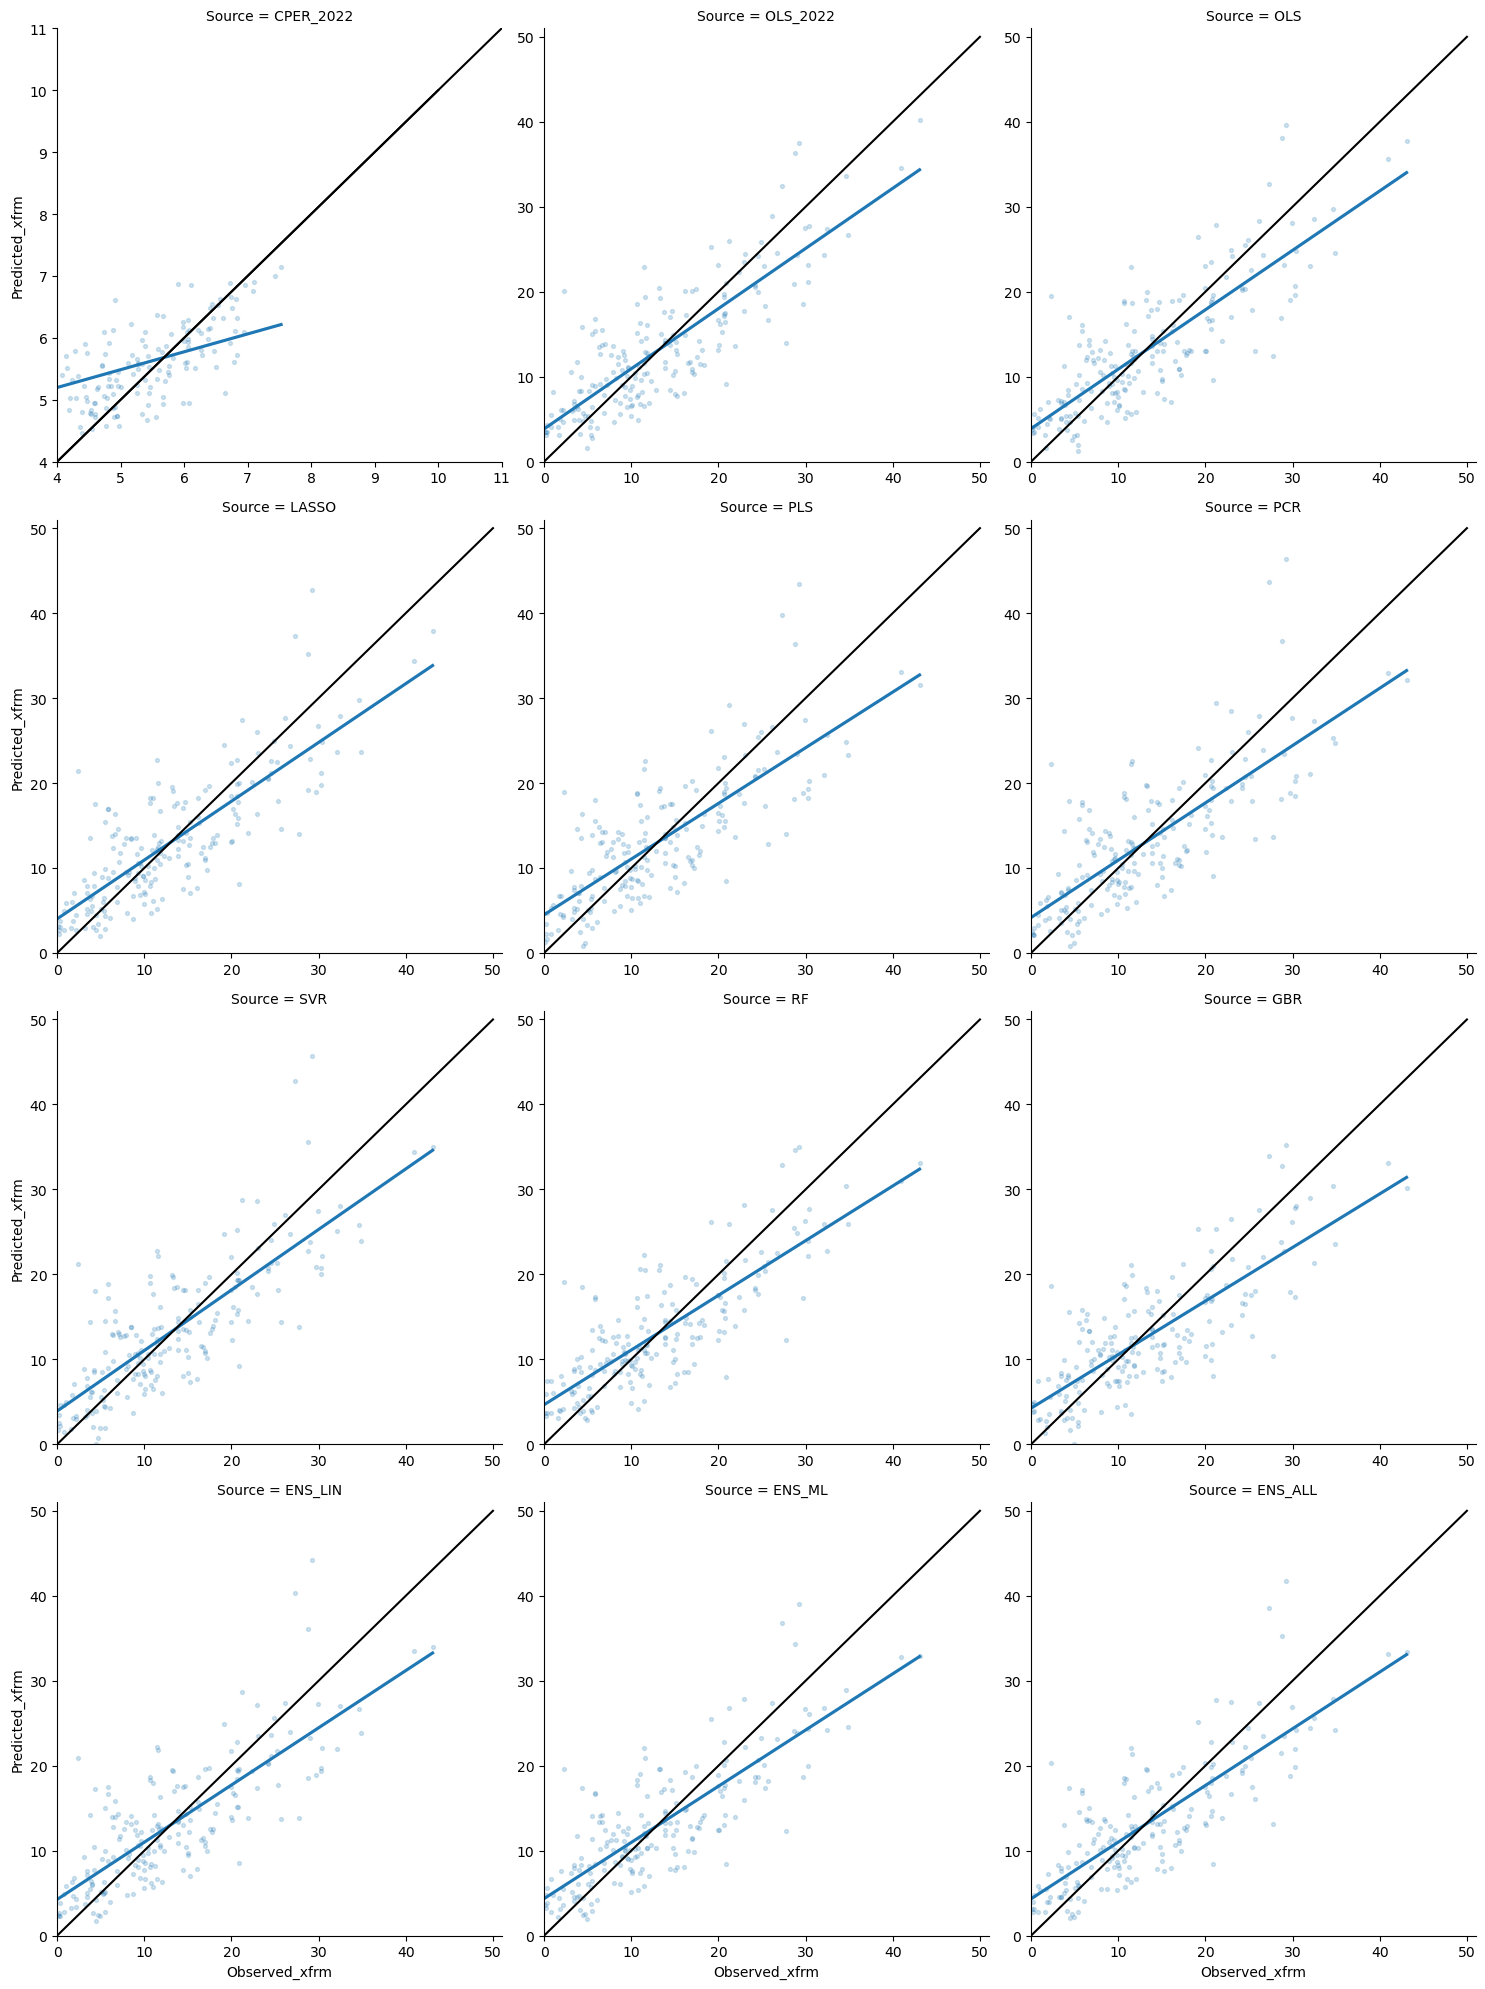

In [40]:
p_obs = sns.lmplot(df_bm_pred,
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3, ci=None,
                   facet_kws=dict(sharey=False, sharex=False,),
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_obs.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.set_xlim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_obs.axes[0].set_ylim((4, 11))
p_obs.axes[0].set_xlim((4, 11))
p_obs.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')

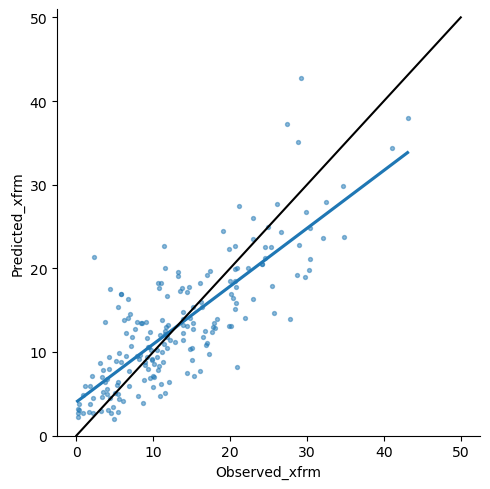

In [41]:
p_obs_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'LASSO'],
               x='Observed_xfrm', y='Predicted_xfrm', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.5, 'edgecolor': None})
for ax in p_obs_best.axes.flatten():
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

In [75]:
mae_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([id_col, date_col]).apply(
        lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']))).mean()).round(2)
bias_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([id_col, date_col]).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])).mean()).round(2)
mae_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([id_col, date_col]).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
bias_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([id_col, date_col]).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed'])).mean()).round(2)
r2_plot = df_bm_pred.groupby([mod_col, logo_group, id_col, date_col]).mean().reset_index().dropna().groupby([mod_col, logo_group], observed=True).apply(
    (lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']))).round(2)
r2_corr_plot = df_bm_pred.groupby([mod_col, logo_group, id_col, date_col]).mean().reset_index().dropna().groupby([mod_col, logo_group], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm'])).round(2)

In [76]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAE_std': mae_plot.unstack(level=0).std().round(2),
    'Bias': bias_plot.unstack(level=0).mean().round(2),
    'Bias_std': bias_plot.unstack(level=0).std().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'R^2_std': r2_plot.unstack(level=0).std().round(2),
    'r': r2_corr_plot.unstack(level=0).mean().round(2),
    'r_std': r2_corr_plot.unstack(level=0).std().round(2),
    'MAE_bt': mae_bt_plot.unstack(level=0).mean().round(2),
    'MAE_bt_std': mae_bt_plot.unstack(level=0).std().round(2),
    'MAE_bt_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True).mean()['Observed']).unstack(level=0).mean().round(2),
    'MAE_bt_pct_std': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                    observed=True).mean()['Observed']).unstack(level=0).std().round(2),
    'Bias_bt': bias_bt_plot.unstack(level=0).mean().round(2),
    'Bias_bt_std': bias_bt_plot.unstack(level=0).std().round(2),
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv(os.path.join(outDIR, 'tables', re.sub('tmp.csv', 'results_plot.csv', os.path.basename(inPATH))))

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'Bias': bias_plot.round(2),
    'MAE_bt': mae_bt_plot.round(2),
    'MAE_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], observed=True).mean()['Observed']).round(2),
    'R^2': r2_plot.round(2),
    'r': r2_corr_plot.round(2)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv(os.path.join(outDIR, 'tables', re.sub('tmp.csv', 'results_plot_yrly.csv', os.path.basename(inPATH))))

,MAE,MAE_std,Bias,Bias_std,R^2,R^2_std,r,r_std,MAE_bt,MAE_bt_std,MAE_bt_pct,MAE_bt_pct_std,Bias_bt,Bias_bt_std
Source,,,,,,,,,,,,,,
CPER_2022,1.49,0.28,1.49,0.28,-12.34,7.64,0.56,0.15,1348.19,165.48,3.17,0.90,1348.19,165.48
OLS_2022,3.56,1.48,-0.37,3.43,-0.11,0.73,0.71,0.16,151.28,79.40,0.33,0.10,-27.79,153.61
OLS,3.46,1.50,-0.62,3.47,-0.12,0.87,0.73,0.10,144.70,78.03,0.31,0.08,-41.26,148.23
LASSO,3.99,1.84,-0.00,3.86,-0.32,0.88,0.66,0.24,171.60,100.95,0.36,0.14,-13.67,171.20
PLS,3.68,1.53,-0.75,3.51,-0.15,0.84,0.71,0.13,155.89,80.99,0.33,0.09,-45.29,154.75
PCR,3.81,1.57,-0.63,3.72,-0.25,0.92,0.70,0.13,161.58,82.87,0.34,0.09,-40.38,163.73
SVR,3.53,1.40,-0.57,3.52,-0.15,0.77,0.76,0.14,149.50,74.77,0.32,0.09,-35.93,154.41
RF,3.81,1.57,-0.84,3.91,-0.36,1.05,0.75,0.13,158.99,83.82,0.34,0.07,-51.88,167.09
GBR,3.94,1.57,-0.58,4.04,-0.37,0.99,0.72,0.13,163.06,79.36,0.36,0.11,-39.86,170.35


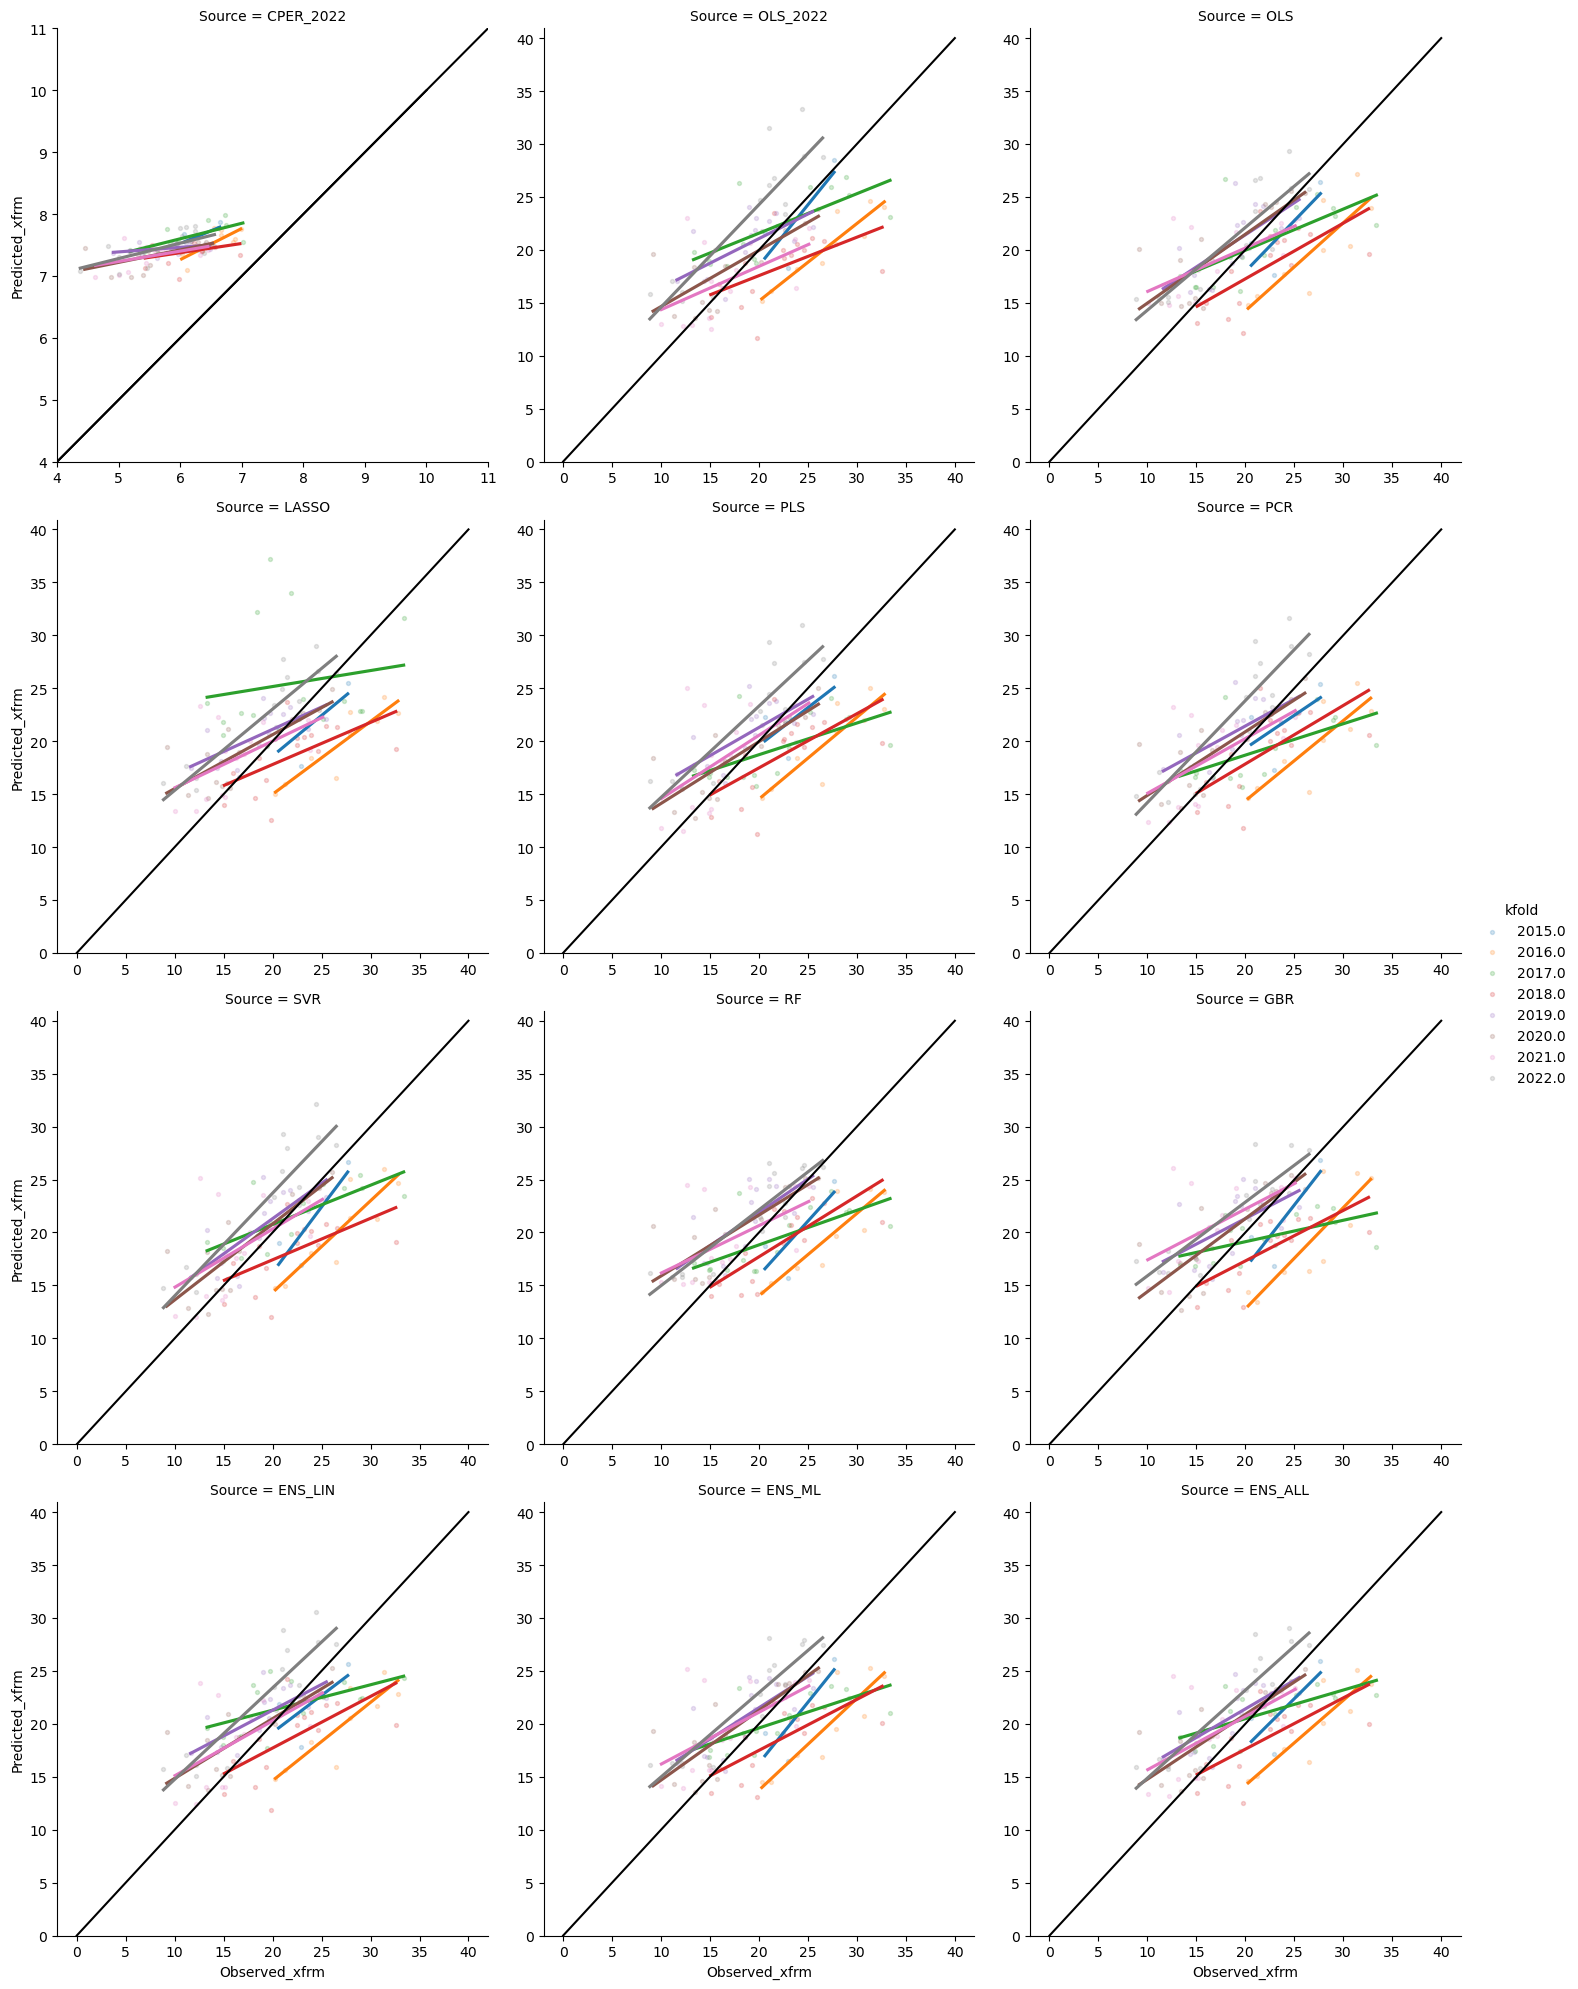

In [77]:
p_plot = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, id_col, date_col]).mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_plot.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_plot.axes[0].set_ylim((4, 11))
p_plot.axes[0].set_xlim((4, 11))
p_plot.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_plot_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'LASSO'],
               x='Observed_xfrm', y='Predicted_xfrm', ci=None, hue=logo_group,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_plot_best.axes.flatten():
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

In [ ]:
df_bm_pred[date_col] = pd.to_datetime(df_bm_pred[date_col])
df_bm_pred['DOY'] = df_bm_pred[date_col].dt.dayofyear
p_plot_ts_best = sns.FacetGrid(hue='Pasture', 
                               data=df_bm_pred[df_bm_pred[mod_col] == 'SVR'].sort_values([id_col, date_col]),
                               row='Pasture', col='Year', sharex=True)
p_plot_ts_best.map(plt.plot, 'DOY', 'Observed', linestyle='solid')
p_plot_ts_best.map(plt.plot, 'DOY', 'Predicted', linestyle='dotted')

In [ ]:
df_bm_pred[date_col] = pd.to_datetime(df_bm_pred[date_col])
df_bm_pred['Year'] = df_bm_pred[date_col].dt.year
df_bm_pred['DOY'] = df_bm_pred[date_col].dt.dayofyear
p_plot_ts_best = sns.FacetGrid(hue='Pasture', 
                               data=df_bm_pred[df_bm_pred[mod_col] == 'SVR'].sort_values([id_col, date_col]),
                               row='Pasture', col='Year', sharex=True)
p_plot_ts_best.map(plt.plot, 'DOY', 'Observed', linestyle='solid')
p_plot_ts_best.map(plt.plot, 'DOY', 'Predicted', linestyle='dotted')

In [ ]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['DOY'] = df['Date'].dt.dayofyear
p = sns.FacetGrid(hue='Pasture', data=df,
            col='Year', col_wrap=3, sharex=True)
p.map(plt.plot, 'DOY', 'DW_kg_ha')
#xformatter = mdates.DateFormatter("%m/%d")
#p.axes[0,0].xaxis.set_major_formatter(xformatter)
#for ax in p.axes.flatten():
#    ax.xaxis.set_major_formatter(myFmt)

In [ ]:
mae_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_pasture = df_bm_pred.groupby([mod_col, past_col] + group_cols, observed=True).mean().reset_index().dropna().groupby([mod_col, logo_group], observed=True).apply(
    lambda x: r2_score(x['Observed'], x['Predicted'])).round(2)
r2_corr_pasture = df_bm_pred.groupby([mod_col, past_col] + group_cols, observed=True).mean().reset_index().dropna().groupby([mod_col, logo_group], observed=True).apply(
    lambda x: r_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [ ]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(2),
    'MAPE': mape_pasture.unstack(level=0).mean().round(2),
    'R^2': r2_pasture.unstack(level=0).mean().round(2),
    'r': r2_corr_pasture.unstack(level=0).mean().round(2)
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.csv')

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(2),
    'MAPE': mape_pasture.round(2),
    'R^2': r2_pasture.round(2),
    'r': r2_corr_pasture.round(2)
})
#display(df_smry_pasture_by_yr.sort_values('r'))
if save_results:
    df_smry_pasture_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '_yearly.csv')

In [ ]:
p_past = sns.lmplot(df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols))).mean().reset_index(),
               x='Observed', y='Predicted', col=mod_col, col_wrap=3,
               hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_past .axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 'ml_yrly_pred_past_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
df_bm_pred['Error'] = df_bm_pred['Predicted'] - df_bm_pred['Observed']
p_plot_error = sns.catplot(y=id_col, x='Error', hue='Year',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h', col='Source', col_wrap=3,# palette=sns.color_palette()[6:-1],
                data=df_bm_pred,
                height=8, aspect=1.0)
for ax in p_plot_error.axes.flatten():
    ax.axvline(x=0, linewidth=1, linestyle='dashed', color='black')

In [ ]:
df_bm_pred[df_bm_pred['Source'] == 'GBR'].groupby('SiteID').mean().sort_values('Error')

In [ ]:
p_past_error = sns.catplot(y=past_col, x='Error', hue='Year',
                orient='h', col='Source', col_wrap=3,# palette=sns.color_palette()[6:-1],
                data=df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols))).mean().reset_index(),
                height=8, aspect=1.0)
for ax in p_past_error.axes.flatten():
    ax.axvline(x=0, linewidth=1, linestyle='dashed', color='black')

In [ ]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)
else:
    p_trans=None

In [ ]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Season', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_pasture_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean', 'Season']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Season', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture_seas.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
df_ols = mod_dict['OLS']['formula_df']

In [ ]:
df_ols

In [ ]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [ ]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['year', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['year'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['year'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(year=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

In [ ]:
def feature_type(f):
    if f in ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']:
        return 'Band'
    elif 'bai' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['year',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [ ]:
df_ols_feats_grp['year'] = df_ols_feats_grp['year'].astype('str')
df_ols_feats_grp['year'] = pd.Categorical(df_ols_feats_grp['year'], 
                                          [str(x) for x in range(min(df_ols_feats_grp['year'].astype(int)),
                                                                 max(df_ols_feats_grp['year'].astype(int))+1)])

In [ ]:
p = sns.catplot(y='features', x='RVIw', hue='year',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)

In [ ]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [ ]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable')['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
p = sns.catplot(df_lasso_coefs, x='Coef_abs', y='Variable', hue='Year', height=8, aspect=1.0, orient='h')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [ ]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)

In [ ]:
df_lasso_coefs.groupby('Year')['Coef'].count()

In [ ]:
df_vip = mod_dict['PLS']['variable_df']
df_vip_ranked = df_vip.groupby('Variable')['VIP'].mean().sort_values(ascending=False)
df_vip['Variable'] = pd.Categorical(df_vip['Variable'], categories=df_vip_ranked.index.values)
df_vip_top = df_vip[df_vip['VIP'] > 1.0].copy()
df_vip_top['Variable'] = df_vip_top['Variable'].cat.remove_unused_categories()
p = sns.catplot(df_vip, x='VIP', y='Variable',  hue='Year', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)

In [ ]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['Year', 'Variable']).apply(lambda x: np.mean(np.abs(x), axis=1))
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable')['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

p = sns.catplot(df_pcr_coefs_mean,
                x='Coef_mean_abs', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_svr_pi = mod_dict['SVR']['variable_df']
df_svr_pi_ranked = df_svr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_svr_pi['Variable'] = pd.Categorical(df_svr_pi['Variable'], categories=df_svr_pi_ranked.index.values)
p = sns.catplot(df_svr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_rf_pi = mod_dict['RF']['variable_df']
df_rf_pi_ranked = df_rf_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_rf_pi['Variable'] = pd.Categorical(df_rf_pi['Variable'], categories=df_rf_pi_ranked.index.values)
p = sns.catplot(df_rf_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_gbr_pi = mod_dict['GBR']['variable_df']
df_gbr_pi_ranked = df_gbr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_gbr_pi['Variable'] = pd.Categorical(df_gbr_pi['Variable'], categories=df_gbr_pi_ranked.index.values)
p = sns.catplot(df_gbr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', row='Year', col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Season', ci=None, order=1,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes.flatten():
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [ ]:
param_dfs = {}
for k in mod_dict:
    if 'tune_results' in mod_dict[k].keys():
        for idx, yr in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][yr]['params']]))
                param_dfs[k] = pd.DataFrame(columns=['Model', 'Year', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'Year': str(yr),
                                   'Best': 0,
                                   'MAPE': mod_dict[k]['tune_results'][yr]['mean_test_MAPE'],
                                   'MSE': mod_dict[k]['tune_results'][yr]['mean_test_MSE'],
                                   'R2': mod_dict[k]['tune_results'][yr]['mean_test_R2'],
                                   'R2_train': mod_dict[k]['tune_results'][yr]['mean_train_R2']})
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][yr]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][yr]['rank_test_MAPE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            param_dfs[k] = pd.concat([param_dfs[k], df_tmp])
        if k in param_dfs.keys():
            param_dfs[k] = param_dfs[k].reset_index(drop=True)

In [ ]:
sns.catplot(x='alpha', y='MAPE', data=param_dfs['LASSO'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_components', y='MAPE', data=param_dfs['PLS'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='pca__n_components', y='MAPE', data=param_dfs['PCR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_samples', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='gamma', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='C', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [ ]:
np.logspace(0.5, 4, 15, base=10)

In [ ]:
sns.catplot(x='learning_rate', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='lr', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='optimizer__momentum', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='optimizer__weight_decay', y='MAPE', data=param_dfs['DNN'], hue='Year', kind='point', aspect=2)

In [ ]:
param_dfs['DNN'][param_dfs['DNN']['Best'] == 1].sort_values('lr')
#mod_dict['DNN2']